In [1]:
import os
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import tifffile
from IPython.display import display
from skimage.filters import gaussian, threshold_otsu
from skimage.morphology import remove_small_objects


Original data shape: (12, 4, 1024, 1024)
Extracted 4 channels from 12 Z-slices
mHTT data shape: (12, 1024, 1024)
CCT1 data shape: (12, 1024, 1024)
Nuclei data shape: (12, 1024, 1024)
Saved 12 Z-slices for mHTT to 'mhtt_z_slices'
Saved 12 Z-slices for CCT1 to 'cct1_z_slices'
Saved 12 Z-slices for nuclei to 'nuclei_z_slices'


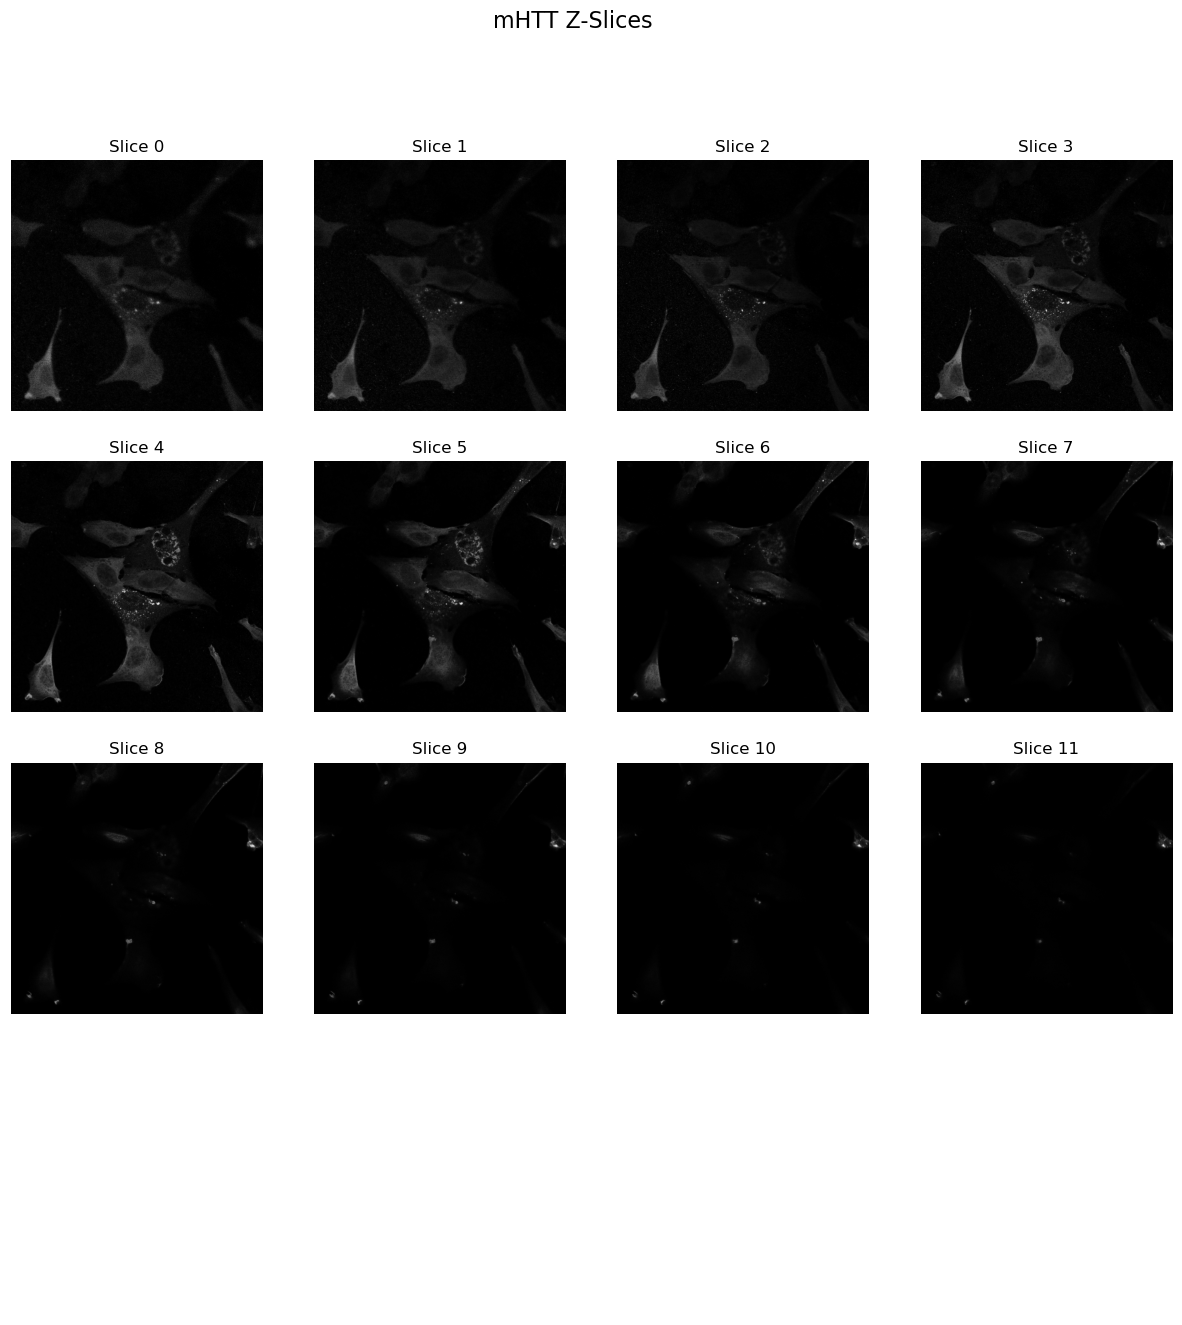

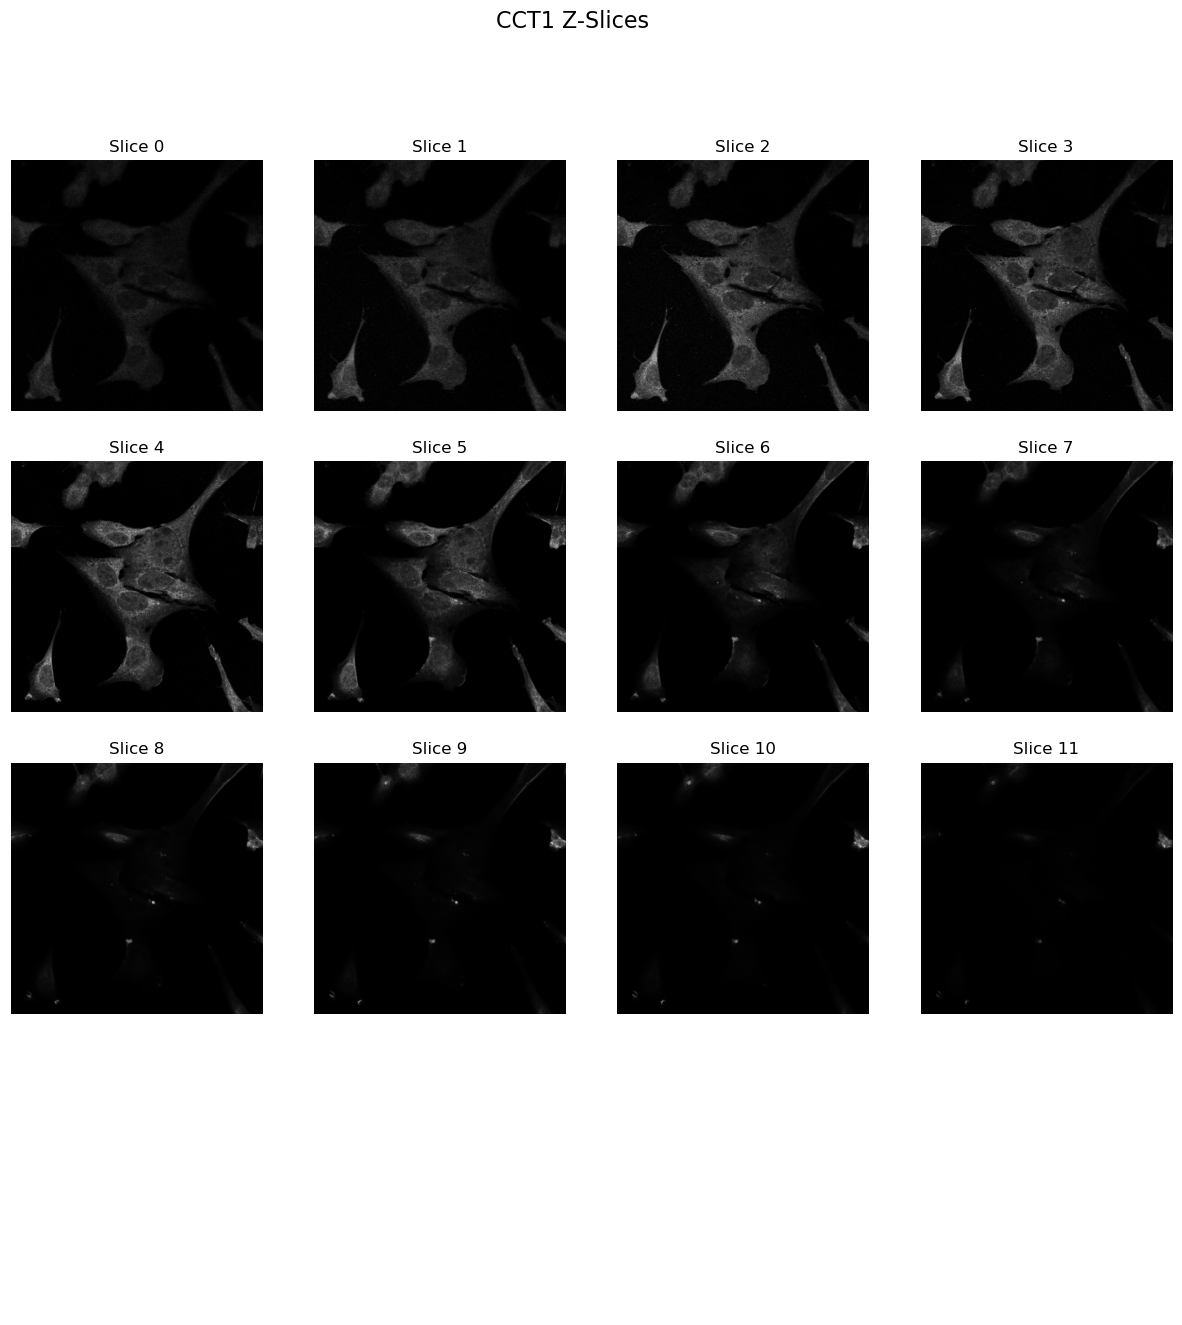

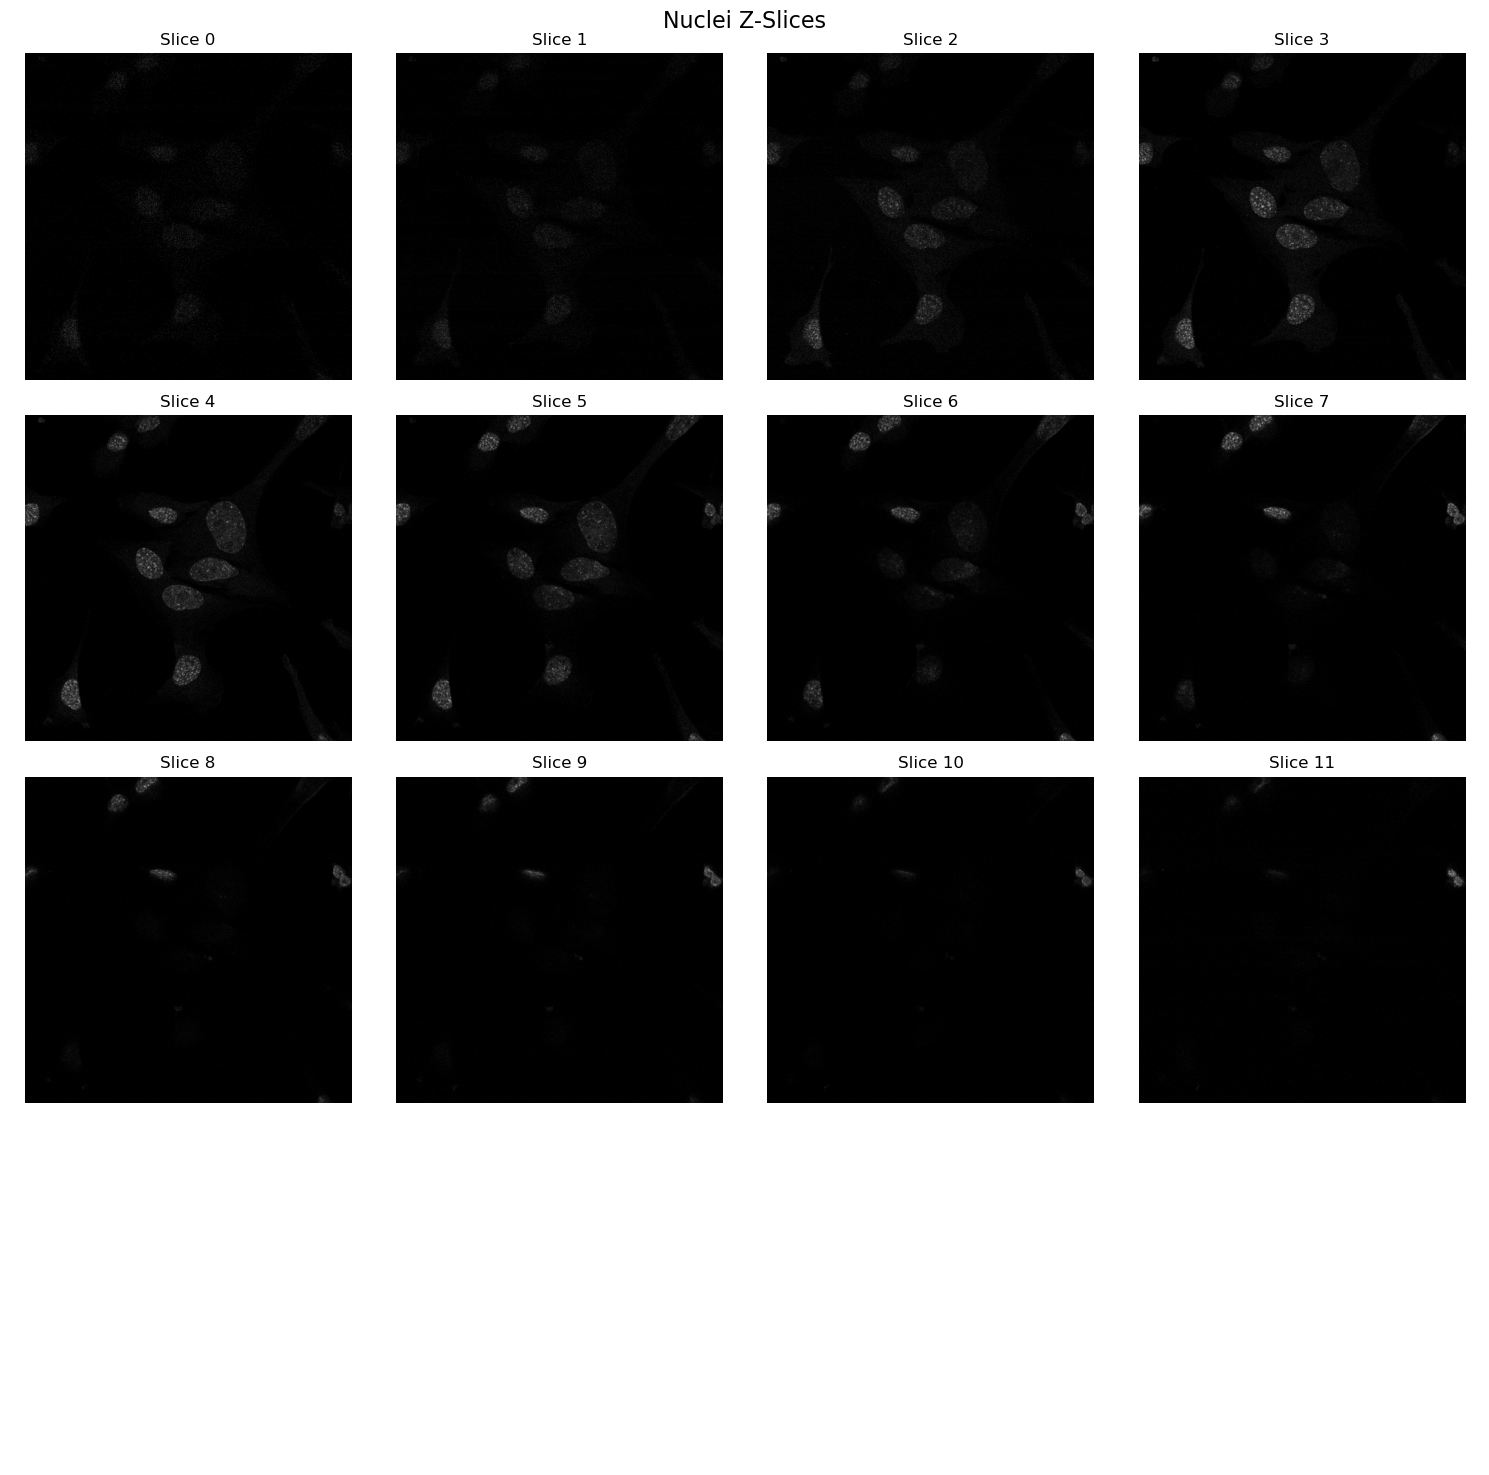

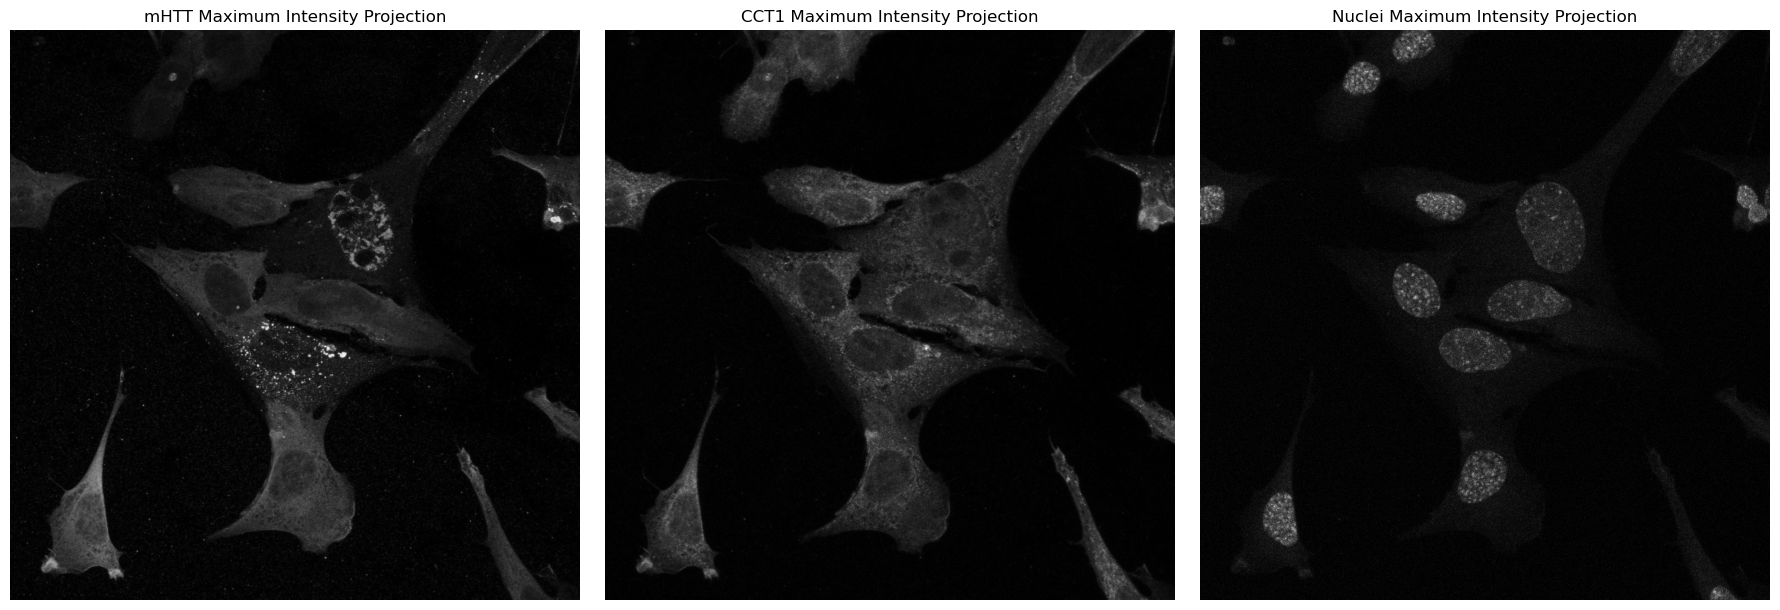

In [2]:
# File path for the multi-channel TIFF file
tif_path = '/Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/z-split tif/20240312_CKR_Exp35_STHdhQ97HA_96h_+BafA_CCT1_635P_HA_580_A11_460L_1.tif'

# Load the multi-channel TIFF file
data = tifffile.imread(tif_path)

# Print the shape to understand the dimensions
print(f"Original data shape: {data.shape}")

# Extract individual channels based on the shape
# Assuming the shape is (Z, C, Y, X) where C is the number of channels
if len(data.shape) == 4:
    # Shape is (Z, C, Y, X) or similar
    num_z, num_channels, height, width = data.shape
    mhtt_data = data[:, 2]  
    cct1_data = data[:, 3]  
    nuclei_data = data[:, 0]  
    print(f"Extracted {num_channels} channels from {num_z} Z-slices")
else:
    # If the shape is different (e.g., channels might be in a different dimension)
    # We need to determine the structure
    print("Expected 4D data (Z, C, Y, X). Please check the TIFF file structure.")
    # As a fallback, try to extract assuming (C, Z, Y, X)
    if len(data.shape) == 4 and data.shape[0] == 3:
        mhtt_data = data[0]
        cct1_data = data[1]
        nuclei_data = data[2]
        print(f"Assuming (C, Z, Y, X) structure, extracted {data.shape[0]} channels")
    else:
        raise ValueError("Couldn't determine the structure of the multi-channel TIFF")

# Verify the shapes
print(f"mHTT data shape: {mhtt_data.shape}")
print(f"CCT1 data shape: {cct1_data.shape}")
print(f"Nuclei data shape: {nuclei_data.shape}")

# Create output directories for Z-slices
mhtt_output_dir = "mhtt_z_slices"
cct1_output_dir = "cct1_z_slices"
nuclei_output_dir = "nuclei_z_slices"
os.makedirs(mhtt_output_dir, exist_ok=True)
os.makedirs(cct1_output_dir, exist_ok=True)
os.makedirs(nuclei_output_dir, exist_ok=True)

# Save each Z-slice as a separate TIFF file
for z in range(mhtt_data.shape[0]):
    mhtt_slice_path = os.path.join(mhtt_output_dir, f"mhtt_slice_{z}.tiff")
    cct1_slice_path = os.path.join(cct1_output_dir, f"cct1_slice_{z}.tiff")
    nuclei_slice_path = os.path.join(nuclei_output_dir, f"nuclei_slice_{z}.tiff")
    
    # Save each channel's Z-slice
    tifffile.imwrite(mhtt_slice_path, mhtt_data[z])
    tifffile.imwrite(cct1_slice_path, cct1_data[z])
    tifffile.imwrite(nuclei_slice_path, nuclei_data[z])

print(f"Saved {mhtt_data.shape[0]} Z-slices for mHTT to '{mhtt_output_dir}'")
print(f"Saved {cct1_data.shape[0]} Z-slices for CCT1 to '{cct1_output_dir}'")
print(f"Saved {nuclei_data.shape[0]} Z-slices for nuclei to '{nuclei_output_dir}'")

# Normalize the intensity for better visualization
def normalize(img):
    return (img - img.min()) / (img.max() - img.min())

# Display all Z-slices in a grid
num_slices = mhtt_data.shape[0]
grid_size = int(np.ceil(np.sqrt(num_slices)))

# Create figures to display Z-slices for all three channels
fig1, axes1 = plt.subplots(grid_size, grid_size, figsize=(15, 15))
fig1.suptitle('mHTT Z-Slices', fontsize=16)

fig2, axes2 = plt.subplots(grid_size, grid_size, figsize=(15, 15))
fig2.suptitle('CCT1 Z-Slices', fontsize=16)

fig3, axes3 = plt.subplots(grid_size, grid_size, figsize=(15, 15))
fig3.suptitle('Nuclei Z-Slices', fontsize=16)

# Plot each Z-slice
for z in range(num_slices):
    row, col = z // grid_size, z % grid_size
    
    # mHTT slice
    ax1 = axes1[row, col]
    ax1.imshow(normalize(mhtt_data[z]), cmap='gray')
    ax1.set_title(f"Slice {z}")
    ax1.axis('off')
    
    # CCT1 slice
    ax2 = axes2[row, col]
    ax2.imshow(normalize(cct1_data[z]), cmap='gray')
    ax2.set_title(f"Slice {z}")
    ax2.axis('off')
    
    # Nuclei slice
    ax3 = axes3[row, col]
    ax3.imshow(normalize(nuclei_data[z]), cmap='gray')
    ax3.set_title(f"Slice {z}")
    ax3.axis('off')

# Turn off remaining empty subplots
for z in range(num_slices, grid_size**2):
    row, col = z // grid_size, z % grid_size
    axes1[row, col].axis('off')
    axes2[row, col].axis('off')
    axes3[row, col].axis('off')

plt.tight_layout()
plt.show()

# Create maximum intensity projections (MIP)
mhtt_mip = np.max(mhtt_data, axis=0)
cct1_mip = np.max(cct1_data, axis=0)
nuclei_mip = np.max(nuclei_data, axis=0)

# Display the MIP images
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(normalize(mhtt_mip), cmap='gray')
plt.title("mHTT Maximum Intensity Projection")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(normalize(cct1_mip), cmap='gray')
plt.title("CCT1 Maximum Intensity Projection")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(normalize(nuclei_mip), cmap='gray')
plt.title("Nuclei Maximum Intensity Projection")
plt.axis('off')

plt.tight_layout()
plt.show()


when combining the slices for visualization, I use a maximum intensity projection (MIP). It works like this:
	•	It goes through each pixel column in the Z-stack (i.e., the same (X, Y) position across all Z-layers).
	•	For each (X, Y) pixel location, I select the maximum intensity value from all Z-slices.
	•	The result is a single 2D image where each pixel shows the brightest value observed in that column of Z-slices.

This just for visualization, the actual analysis is performed across different z-slices

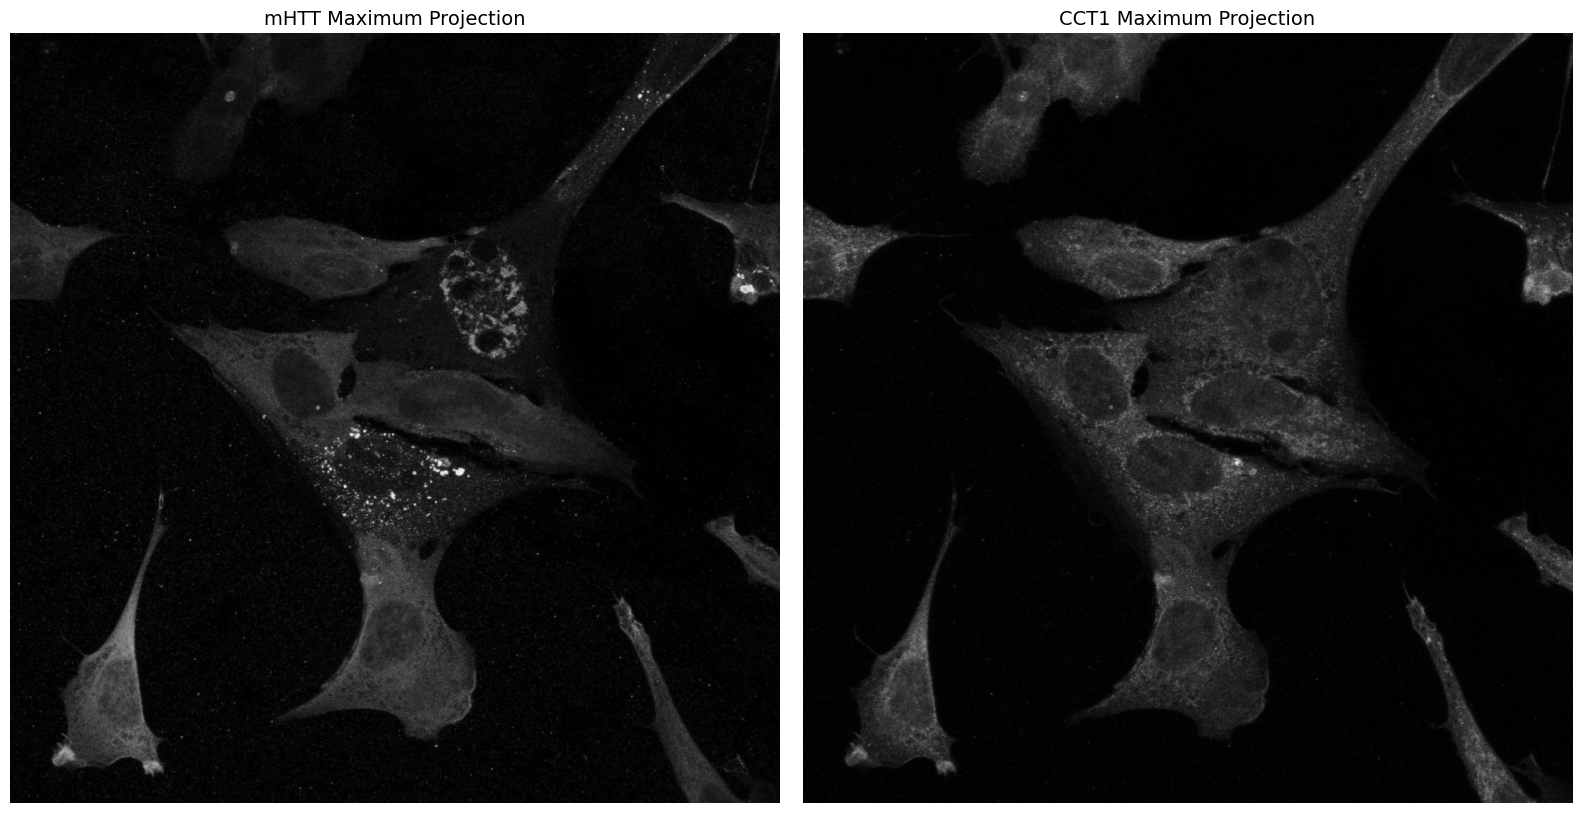

Button(button_style='info', description='Run Colocalization Analysis', style=ButtonStyle(), tooltip='Calculate…

Output()

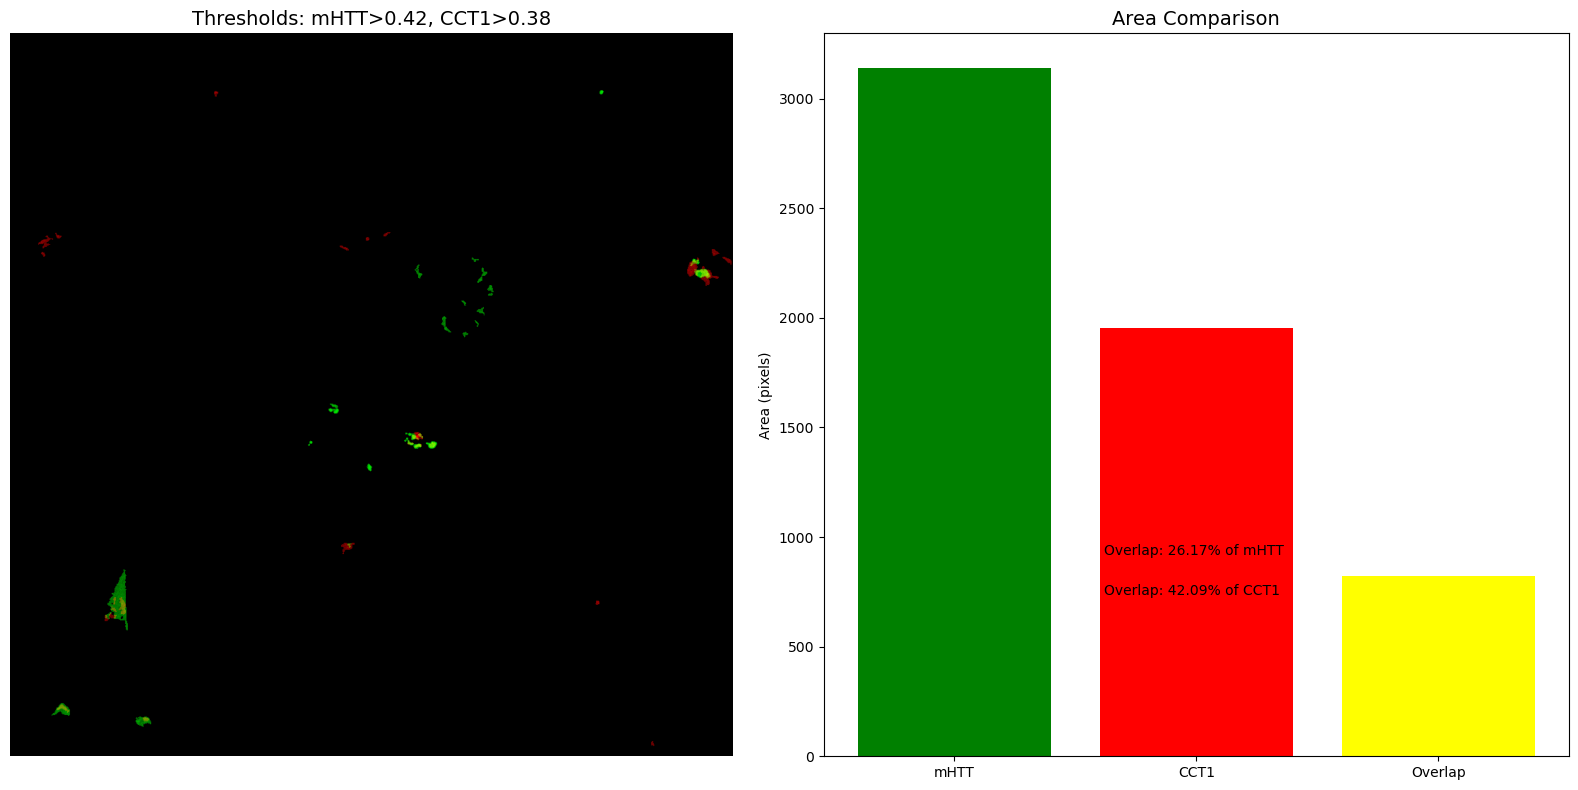

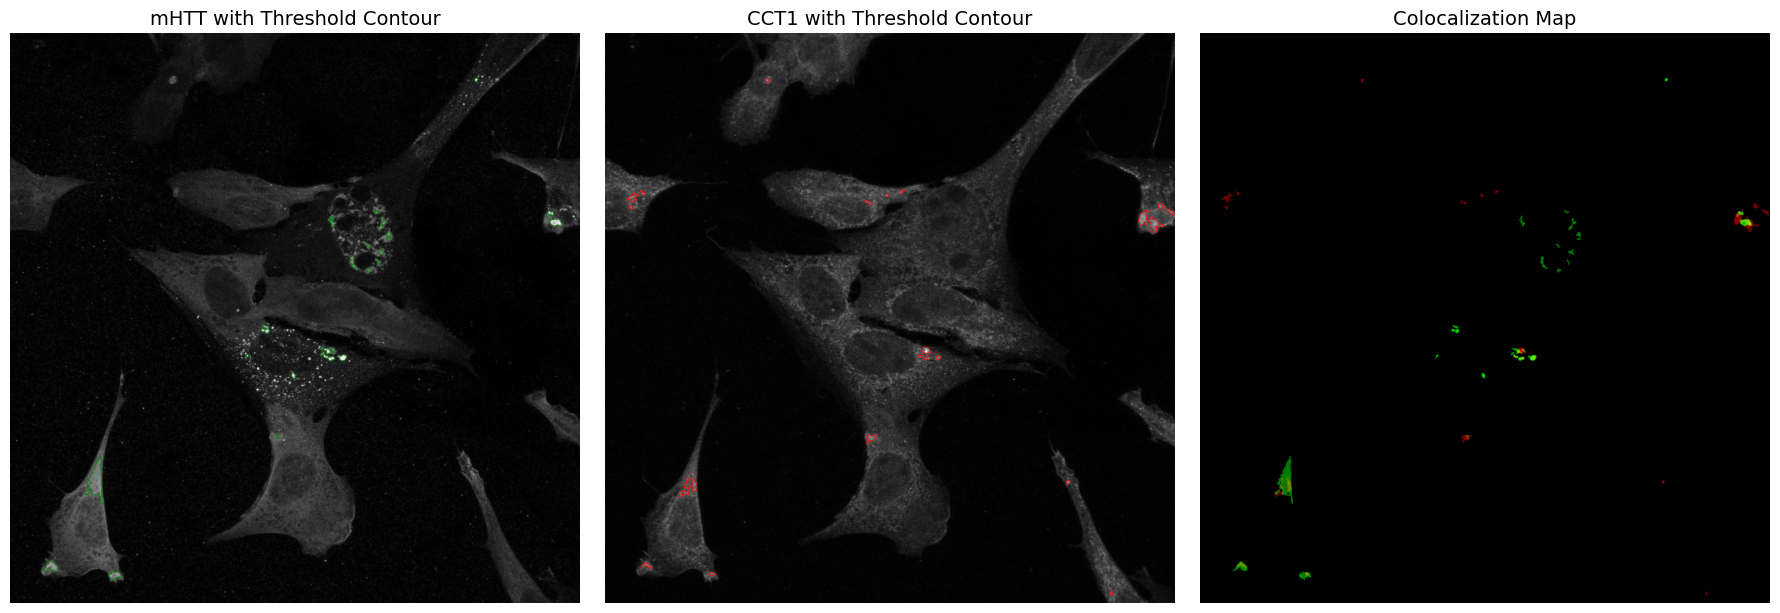

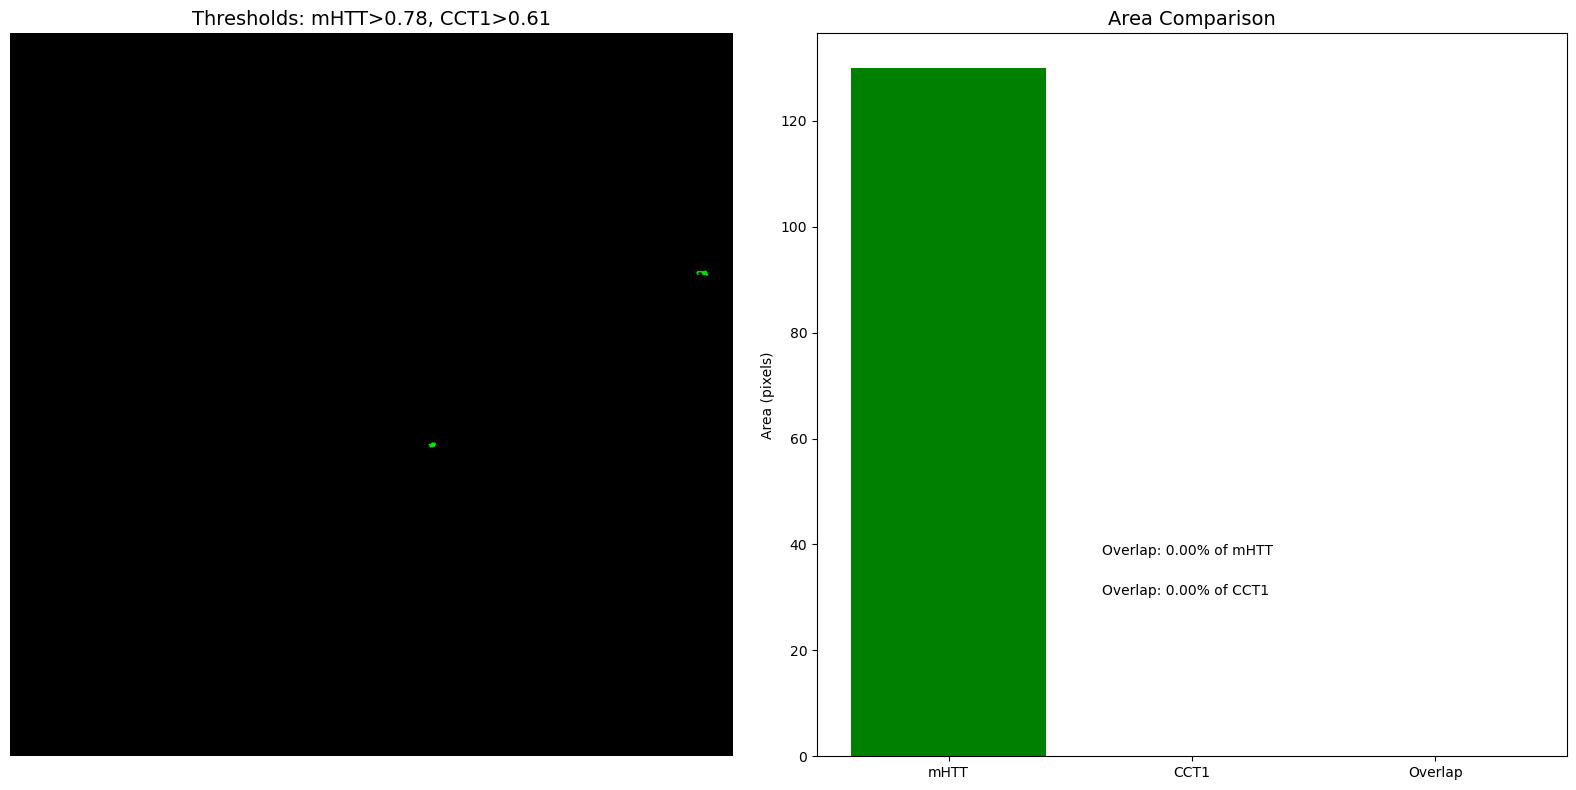

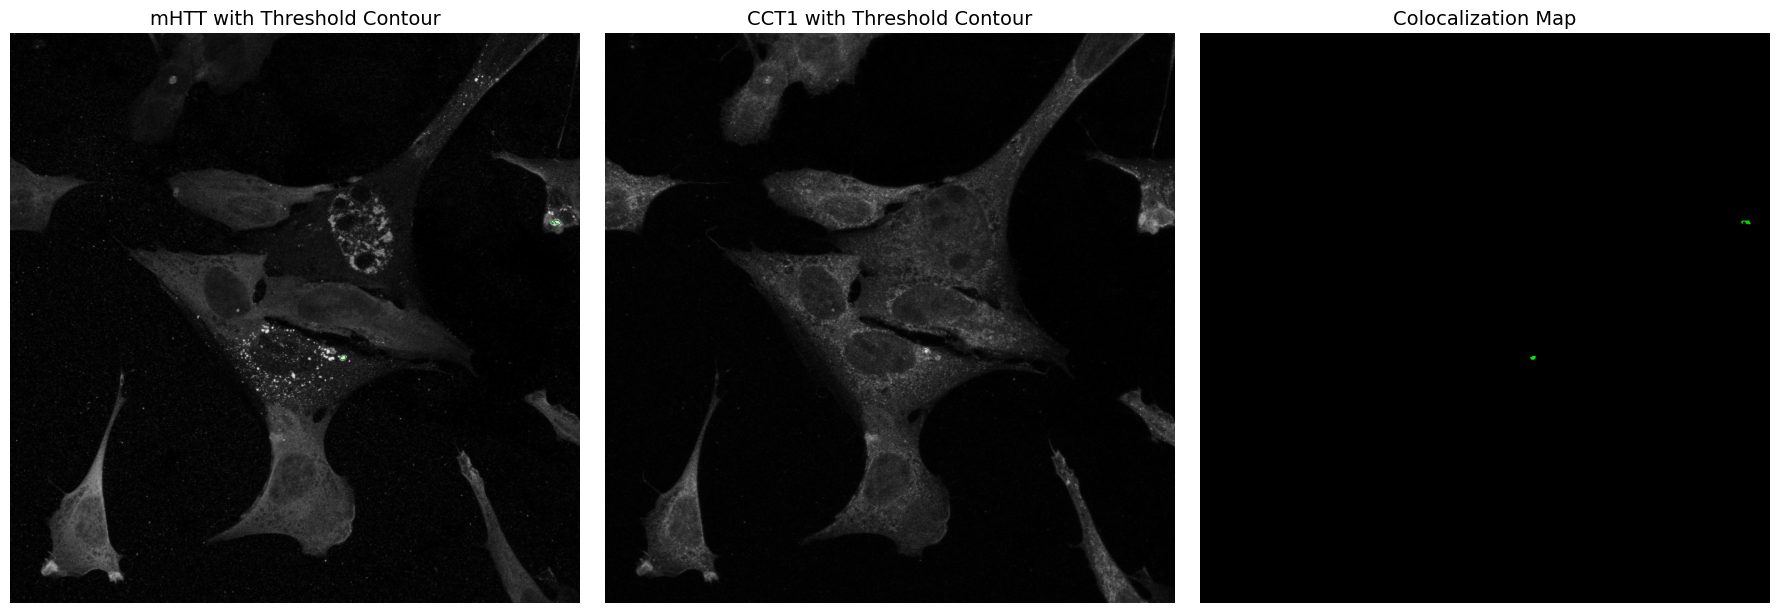

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import pearsonr, mannwhitneyu
import datetime
import os

# Use already loaded data instead of reading from files
# mhtt_data and cct1_data are already available in the notebook

# Create a maximum intensity projection
mhtt_proj = np.max(mhtt_data, axis=0)
cct1_proj = np.max(cct1_data, axis=0)

# Normalize to 0-1 range for better visualization
mhtt_norm = (mhtt_proj - np.min(mhtt_proj)) / np.ptp(mhtt_proj)
cct1_norm = (cct1_proj - np.min(cct1_proj)) / np.ptp(cct1_proj)

# Display the mHTT and CCT1 images side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(mhtt_norm, cmap='gray')
axs[0].set_title("mHTT Maximum Projection", fontsize=14)
axs[0].axis('off')

axs[1].imshow(cct1_norm, cmap='gray')
axs[1].set_title("CCT1 Maximum Projection", fontsize=14)
axs[1].axis('off')
plt.tight_layout()
plt.show()

# Add interactive controls using ipywidgets

def update_visualization(mhtt_strictness=4.0, cct1_strictness=4.0, 
                         sigma=1.0, min_size=20, mhtt_color='green', 
                         cct1_color='red', show_overlap_only=False):
    """Update visualization based on slider values"""
    # Apply Gaussian blur with adjustable sigma
    mhtt_smooth = gaussian(mhtt_norm, sigma=sigma)
    cct1_smooth = gaussian(cct1_norm, sigma=sigma)
    
    # Get Otsu thresholds
    mhtt_otsu = threshold_otsu(mhtt_smooth)
    cct1_otsu = threshold_otsu(cct1_smooth)
    
    # Apply strictness factor from sliders
    mhtt_threshold = min(1.0, mhtt_otsu * mhtt_strictness)
    cct1_threshold = min(1.0, cct1_otsu * cct1_strictness)
    
    # Create binary masks
    mhtt_mask = mhtt_smooth > mhtt_threshold
    cct1_mask = cct1_smooth > cct1_threshold
    
    # Clean up small noise artifacts
    mhtt_mask = remove_small_objects(mhtt_mask, min_size=min_size)
    cct1_mask = remove_small_objects(cct1_mask, min_size=min_size)
    
    # Create an overlap mask where both are active
    overlap_mask = mhtt_mask & cct1_mask
    
    # Prepare color mapping - using RGB channels directly for better control
    composite = np.zeros((mhtt_norm.shape[0], mhtt_norm.shape[1], 3))
    
    # Configure colors based on selections
    color_map = {'red': 0, 'green': 1, 'blue': 2, 'magenta': [0,2], 'yellow': [0,1], 'cyan': [1,2]}
    
    if not show_overlap_only:
        # Add mHTT channel
        if mhtt_color in ['red', 'green', 'blue']:
            composite[:,:,color_map[mhtt_color]] = mhtt_norm * mhtt_mask
        else:  # Handle combined colors
            for channel in color_map[mhtt_color]:
                composite[:,:,channel] = mhtt_norm * mhtt_mask
        
        # Add CCT1 channel
        if cct1_color in ['red', 'green', 'blue']:
            composite[:,:,color_map[cct1_color]] = cct1_norm * cct1_mask
        else:  # Handle combined colors
            for channel in color_map[cct1_color]:
                composite[:,:,channel] = cct1_norm * cct1_mask
    else:
        # Only show overlap
        if mhtt_color in ['red', 'green', 'blue'] and cct1_color in ['red', 'green', 'blue']:
            composite[:,:,color_map[mhtt_color]] = mhtt_norm * overlap_mask
            composite[:,:,color_map[cct1_color]] = cct1_norm * overlap_mask
    
    # Calculate metrics
    mhtt_area = np.sum(mhtt_mask)
    cct1_area = np.sum(cct1_mask)
    overlap_area = np.sum(overlap_mask)
    
    # Display the results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Image display
    ax1.imshow(composite)
    
    # Create informative title
    title = f"Thresholds: mHTT>{mhtt_threshold:.2f}, CCT1>{cct1_threshold:.2f}"
    if show_overlap_only:
        title += " (Overlap Only)"
    ax1.set_title(title, fontsize=14)
    ax1.axis('off')
    
    # Add metrics visualization
    ax2.bar(['mHTT', 'CCT1', 'Overlap'], [mhtt_area, cct1_area, overlap_area], 
           color=['green', 'red', 'yellow'])
    ax2.set_title("Area Comparison", fontsize=14)
    ax2.set_ylabel("Area (pixels)")
    
    # Overlap percentages as text
    overlap_pct_mhtt = 100*overlap_area/mhtt_area if mhtt_area > 0 else 0
    overlap_pct_cct1 = 100*overlap_area/cct1_area if cct1_area > 0 else 0
    plt.figtext(0.7, 0.3, f"Overlap: {overlap_pct_mhtt:.2f}% of mHTT")
    plt.figtext(0.7, 0.25, f"Overlap: {overlap_pct_cct1:.2f}% of CCT1")
    
    plt.tight_layout()
    plt.show()
    
    # Return values for potential saving
    return {
        'composite': composite,
        'mhtt_mask': mhtt_mask,
        'cct1_mask': cct1_mask,
        'overlap_mask': overlap_mask,
        'metrics': {
            'mhtt_area': mhtt_area,
            'cct1_area': cct1_area,
            'overlap_area': overlap_area,
            'overlap_pct_mhtt': overlap_pct_mhtt,
            'overlap_pct_cct1': overlap_pct_cct1
        },
        'thresholds': {
            'mhtt_threshold': mhtt_threshold,
            'cct1_threshold': cct1_threshold
        }
    }

# Function to run comprehensive colocalization analysis
def run_colocalization_analysis(b):
    """Generate comprehensive colocalization metrics and PDF report"""
    # Create directory for reports if it doesn't exist
    report_dir = "colocalization_reports"
    if not os.path.exists(report_dir):
        os.makedirs(report_dir)
    
    # Generate timestamp for the filename
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    pdf_filename = os.path.join(report_dir, f"colocalization_report_{timestamp}.pdf")
    
    # Get current parameter values
    mhtt_strictness = mhtt_strictness_slider.value
    cct1_strictness = cct1_strictness_slider.value
    sigma = sigma_slider.value
    min_size = min_size_slider.value
    
    # Get results with current parameters
    results = update_visualization(
        mhtt_strictness, cct1_strictness, sigma, min_size, 
        mhtt_color.value, cct1_color.value, overlap_toggle.value
    )
    
    mhtt_mask = results['mhtt_mask']
    cct1_mask = results['cct1_mask']
    overlap_mask = results['overlap_mask']
    mhtt_threshold = results['thresholds']['mhtt_threshold']
    cct1_threshold = results['thresholds']['cct1_threshold']
    
    # Create union mask
    union_mask = mhtt_mask | cct1_mask
    
    # 1. Pearson's Correlation Coefficient
    # Get intensity values within the masks
    mhtt_values = mhtt_norm[union_mask]
    cct1_values = cct1_norm[union_mask]
    pearson_corr, pearson_p = pearsonr(mhtt_values, cct1_values)
    
    # 2. Manders' Coefficients
    # M1: fraction of mHTT overlapping with CCT1
    m1 = np.sum(mhtt_norm * overlap_mask) / np.sum(mhtt_norm * mhtt_mask) if np.sum(mhtt_norm * mhtt_mask) > 0 else 0
    # M2: fraction of CCT1 overlapping with mHTT
    m2 = np.sum(cct1_norm * overlap_mask) / np.sum(cct1_norm * cct1_mask) if np.sum(cct1_norm * cct1_mask) > 0 else 0
    
    # 3. Dice similarity coefficient
    dice = 2 * np.sum(overlap_mask) / (np.sum(mhtt_mask) + np.sum(cct1_mask)) if (np.sum(mhtt_mask) + np.sum(cct1_mask)) > 0 else 0
    
    # 4. Mann-Whitney U Test
    # Compare intensity distributions within the two masks
    mhtt_inside = mhtt_norm[mhtt_mask & ~cct1_mask].flatten()
    mhtt_overlap = mhtt_norm[overlap_mask].flatten()
    if len(mhtt_inside) > 0 and len(mhtt_overlap) > 0:
        u_stat, p_value = mannwhitneyu(mhtt_inside, mhtt_overlap, alternative='two-sided')
    else:
        u_stat, p_value = 0, 1
    
    # 5. Cohen's d (effect size)
    if len(mhtt_inside) > 0 and len(mhtt_overlap) > 0:
        mean_in = np.mean(mhtt_overlap)
        mean_out = np.mean(mhtt_inside)
        std_in = np.std(mhtt_overlap)
        std_out = np.std(mhtt_inside)
        pooled_std = np.sqrt(((len(mhtt_overlap) - 1) * std_in**2 + (len(mhtt_inside) - 1) * std_out**2) / 
                             (len(mhtt_overlap) + len(mhtt_inside) - 2))
        cohen_d = abs(mean_in - mean_out) / pooled_std if pooled_std > 0 else 0
    else:
        mean_in, mean_out, cohen_d = 0, 0, 0
    
    # 6. Intersection over Union (IoU)
    iou = np.sum(overlap_mask) / np.sum(union_mask) if np.sum(union_mask) > 0 else 0
    
    # Display results
    print("\n===== COLOCALIZATION ANALYSIS RESULTS =====")
    print(f"Parameters: mHTT factor={mhtt_strictness}, CCT1 factor={cct1_strictness}, sigma={sigma}, min_size={min_size}")
    print(f"Thresholds: mHTT>{mhtt_threshold:.4f}, CCT1>{cct1_threshold:.4f}")
    
    print("\n1. Pearson's Correlation Coefficient:")
    print(f"   r = {pearson_corr:.4f} (p-value: {pearson_p:.8e})")
    
    print("\n2. Manders' Coefficients:")
    print(f"   M1 (fraction of mHTT overlapping with CCT1) = {m1:.4f}")
    print(f"   M2 (fraction of CCT1 overlapping with mHTT) = {m2:.4f}")
    
    print("\n3. Dice Similarity Coefficient:")
    print(f"   Dice = {dice:.4f}")
    
    print("\n4. Mann-Whitney U Test:")
    print(f"   U = {u_stat:.2f}")
    print(f"   p-value = {p_value:.8e}")
    
    print("\n5. Cohen's d (Effect Size):")
    print(f"   d = {cohen_d:.4f}")
    print(f"   Mean intensity in overlap: {mean_in:.2f}")
    print(f"   Mean intensity outside overlap: {mean_out:.2f}")
    
    print("\n6. Intersection over Union (IoU):")
    print(f"   IoU = {iou:.4f}")
    
    # Create figures for PDF export
    # Visualization of results
    fig_results, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Show mHTT with mask outline
    axs[0].imshow(mhtt_norm, cmap='gray')
    axs[0].contour(mhtt_mask, colors='green', linewidths=0.5)
    axs[0].set_title("mHTT with Threshold Contour", fontsize=14)
    axs[0].axis('off')
    
    # Show CCT1 with mask outline
    axs[1].imshow(cct1_norm, cmap='gray')
    axs[1].contour(cct1_mask, colors='red', linewidths=0.5)
    axs[1].set_title("CCT1 with Threshold Contour", fontsize=14)
    axs[1].axis('off')
    
    # Show overlap visualization
    overlap_img = np.zeros((mhtt_norm.shape[0], mhtt_norm.shape[1], 3))
    overlap_img[:,:,1] = mhtt_norm * mhtt_mask  # Green channel for mHTT
    overlap_img[:,:,0] = cct1_norm * cct1_mask  # Red channel for CCT1
    overlap_img = np.clip(overlap_img, 0, 1)
    
    axs[2].imshow(overlap_img)
    axs[2].set_title("Colocalization Map", fontsize=14)
    axs[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Create PDF report
    with PdfPages(pdf_filename) as pdf:
        # Title page
        fig_title = plt.figure(figsize=(8.5, 11))
        fig_title.suptitle("Colocalization Analysis Report", fontsize=16, y=0.95)
        plt.figtext(0.5, 0.85, f"Generated on: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", 
                   ha='center', fontsize=12)
        plt.figtext(0.5, 0.72, "Analysis Parameters:", ha='center', fontsize=12, weight='bold')
        plt.figtext(0.5, 0.68, f"mHTT threshold factor: {mhtt_strictness}", ha='center', fontsize=10)
        plt.figtext(0.5, 0.65, f"CCT1 threshold factor: {cct1_strictness}", ha='center', fontsize=10)
        plt.figtext(0.5, 0.62, f"Gaussian sigma: {sigma}", ha='center', fontsize=10)
        plt.figtext(0.5, 0.59, f"Min object size: {min_size} pixels", ha='center', fontsize=10)
        plt.figtext(0.5, 0.56, f"mHTT color: {mhtt_color.value}", ha='center', fontsize=10)
        plt.figtext(0.5, 0.53, f"CCT1 color: {cct1_color.value}", ha='center', fontsize=10)
        plt.axis('off')
        pdf.savefig(fig_title)
        plt.close(fig_title)
        
        # Results summary page
        fig_summary = plt.figure(figsize=(8.5, 11))
        fig_summary.suptitle("Colocalization Metrics Summary", fontsize=16, y=0.95)
        
        # Basic metrics
        plt.figtext(0.1, 0.90, "Basic Metrics:", fontsize=12, weight='bold')
        plt.figtext(0.1, 0.87, f"mHTT area: {np.sum(mhtt_mask)} pixels", fontsize=10)
        plt.figtext(0.1, 0.84, f"CCT1 area: {np.sum(cct1_mask)} pixels", fontsize=10)
        plt.figtext(0.1, 0.81, f"Overlap area: {np.sum(overlap_mask)} pixels", fontsize=10)
        plt.figtext(0.1, 0.78, f"Overlap percentage: {100*np.sum(overlap_mask)/np.sum(mhtt_mask):.2f}% of mHTT, {100*np.sum(overlap_mask)/np.sum(cct1_mask):.2f}% of CCT1", fontsize=10)
        
        # Detailed metrics
        plt.figtext(0.1, 0.73, "1. Pearson's Correlation Coefficient:", fontsize=12, weight='bold')
        plt.figtext(0.1, 0.70, f"   r = {pearson_corr:.4f} (p-value: {pearson_p:.8e})", fontsize=10)
        
        plt.figtext(0.1, 0.65, "2. Manders' Coefficients:", fontsize=12, weight='bold')
        plt.figtext(0.1, 0.62, f"   M1 (fraction of mHTT overlapping with CCT1) = {m1:.4f}", fontsize=10)
        plt.figtext(0.1, 0.59, f"   M2 (fraction of CCT1 overlapping with mHTT) = {m2:.4f}", fontsize=10)
        
        plt.figtext(0.1, 0.54, "3. Dice Similarity Coefficient:", fontsize=12, weight='bold')
        plt.figtext(0.1, 0.51, f"   Dice = {dice:.4f}", fontsize=10)
        
        plt.figtext(0.1, 0.46, "4. Mann-Whitney U Test:", fontsize=12, weight='bold')
        plt.figtext(0.1, 0.43, f"   U = {u_stat:.2f}", fontsize=10)
        plt.figtext(0.1, 0.40, f"   p-value = {p_value:.8e}", fontsize=10)
        
        plt.figtext(0.1, 0.35, "5. Cohen's d (Effect Size):", fontsize=12, weight='bold')
        plt.figtext(0.1, 0.32, f"   d = {cohen_d:.4f}", fontsize=10)
        plt.figtext(0.1, 0.29, f"   Mean intensity in overlap: {mean_in:.2f}", fontsize=10)
        plt.figtext(0.1, 0.26, f"   Mean intensity outside overlap: {mean_out:.2f}", fontsize=10)
        
        plt.figtext(0.1, 0.21, "6. Intersection over Union (IoU):", fontsize=12, weight='bold')
        plt.figtext(0.1, 0.18, f"   IoU = {iou:.4f}", fontsize=10)
        
        plt.figtext(0.5, 0.05, f"Report saved to: {pdf_filename}", ha='center', fontsize=8, style='italic')
        plt.axis('off')
        pdf.savefig(fig_summary)
        plt.close(fig_summary)
        
        # Add visualization page
        pdf.savefig(fig_results)
        plt.close(fig_results)
        
    print(f"\nPDF report generated and saved to: {pdf_filename}")

def save_results(b):
    """Save current visualization and metrics to files"""
    # Get current values
    results = update_visualization(
        mhtt_strictness=mhtt_strictness_slider.value,
        cct1_strictness=cct1_strictness_slider.value,
        sigma=sigma_slider.value,
        min_size=min_size_slider.value,
        mhtt_color=mhtt_color.value,
        cct1_color=cct1_color.value,
        show_overlap_only=overlap_toggle.value
    )
    
    # Save composite image
    plt.imsave('colocalization_result.png', results['composite'])
    
    # Save metrics as CSV
    with open('colocalization_metrics.csv', 'w') as f:
        f.write(f"Parameter,Value\n")
        f.write(f"mHTT_area,{results['metrics']['mhtt_area']}\n")
        f.write(f"CCT1_area,{results['metrics']['cct1_area']}\n")
        f.write(f"Overlap_area,{results['metrics']['overlap_area']}\n")
        f.write(f"Overlap_pct_mhtt,{results['metrics']['overlap_pct_mhtt']}\n")
        f.write(f"Overlap_pct_cct1,{results['metrics']['overlap_pct_cct1']}\n")
    
    print(f"Results saved as 'colocalization_result.png' and 'colocalization_metrics.csv'")

# Create sliders
mhtt_strictness_slider = widgets.FloatSlider(
    value=4.0, min=1.0, max=10.0, step=0.5, 
    description='mHTT Factor:',
    style={'description_width': 'initial'}
)

cct1_strictness_slider = widgets.FloatSlider(
    value=4.0, min=1.0, max=10.0, step=0.5, 
    description='CCT1 Factor:',
    style={'description_width': 'initial'}
)

sigma_slider = widgets.FloatSlider(
    value=1.0, min=0.1, max=5.0, step=0.1,
    description='Gaussian σ:',
    style={'description_width': 'initial'}
)

min_size_slider = widgets.IntSlider(
    value=20, min=1, max=100, step=5,
    description='Min Size:',
    style={'description_width': 'initial'}
)

mhtt_color = widgets.Dropdown(
    options=['red', 'green', 'blue', 'magenta', 'yellow', 'cyan'],
    value='green',
    description='mHTT Color:',
    style={'description_width': 'initial'}
)

cct1_color = widgets.Dropdown(
    options=['red', 'green', 'blue', 'magenta', 'yellow', 'cyan'],
    value='red',
    description='CCT1 Color:',
    style={'description_width': 'initial'}
)

overlap_toggle = widgets.Checkbox(
    value=False,
    description='Show overlap only',
    style={'description_width': 'initial'}
)

# Add buttons for save and colocalization analysis
save_button = widgets.Button(
    description='Save Results',
    button_style='success'
)
save_button.on_click(save_results)

colocalize_button = widgets.Button(
    description='Run Colocalization Analysis',
    button_style='info',
    tooltip='Calculate advanced colocalization metrics and generate PDF report'
)
colocalize_button.on_click(run_colocalization_analysis)

# Organize widgets in tabs
threshold_controls = widgets.VBox([
    widgets.HBox([mhtt_strictness_slider, cct1_strictness_slider]),
    widgets.HBox([sigma_slider, min_size_slider])
])

color_controls = widgets.VBox([
    widgets.HBox([mhtt_color, cct1_color]),
    widgets.HBox([overlap_toggle, save_button])
])

tab = widgets.Tab([threshold_controls, color_controls])
tab.set_title(0, 'Thresholding')
tab.set_title(1, 'Appearance')

# Create interactive output
out = widgets.interactive_output(
    update_visualization,
    {
        'mhtt_strictness': mhtt_strictness_slider,
        'cct1_strictness': cct1_strictness_slider,
        'sigma': sigma_slider,
        'min_size': min_size_slider,
        'mhtt_color': mhtt_color,
        'cct1_color': cct1_color,
        'show_overlap_only': overlap_toggle
    }
)

# Display the widgets
display(tab, colocalize_button, out)
